In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

In [2]:
# Loading datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Drop random column
train = train.drop(columns = 'Unnamed: 0')

# Changing the values of the response variable
train['readmitted'] = train['readmitted'].replace(-1, 0)
test['readmitted'] = test['readmitted'].replace(-1, 0)

In [12]:
# Filtering the dataset so that it only has not-readmitted vals
no_readmit = train[train['readmitted'] == 0]
readmit = train[train['readmitted'] == 1]

# Taking a random sample from the no_reamit df 
import random

n = 5041 # To get a 50-50 split, we need a sample of 5041
no_readmit1 = no_readmit.sample(n)

no_readmit.shape # (52173, 48)
readmit.shape # (5041, 48)
no_readmit1.shape # (5041, 48)

# Merging the no_readmit1 and readmit dfs to get a train1 df
merged_df = pd.concat([no_readmit1, readmit])
merged_df.shape

# Randomly shuffling the resulting df
train1 = merged_df.sample(frac=1)
train1.shape

(10023, 49)

In [13]:
# Correlations with response
train1.corrwith(train1.readmitted).sort_values()

encounter_id               -0.080317
num_procedures             -0.008595
patient_nbr                -0.005732
admission_type_id          -0.002068
discharge_disposition_id    0.013787
admission_source_id         0.017602
number_outpatient           0.024717
num_of_changes              0.032581
num_lab_procedures          0.056465
number_emergency            0.056493
age                         0.063134
num_medications             0.064858
number_diagnoses            0.076780
time_in_hospital            0.083322
number_inpatient            0.124416
readmitted                  1.000000
dtype: float64

In [29]:
train.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'num_of_changes'],
      dtype='object')

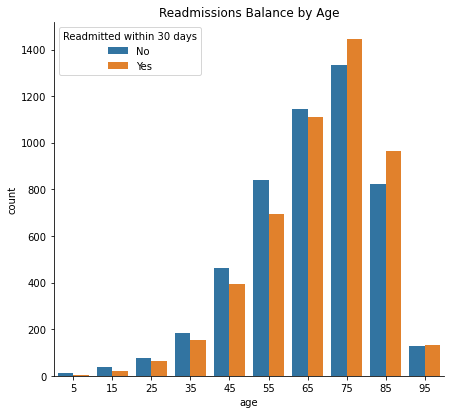

In [31]:
b = train1.age.unique()
b.sort()
b_sort = np.array(b).tolist()


ageplt = sns.countplot(x = 'age', hue = 'readmitted', data = train1, order = b_sort) 

sns.despine()
ageplt.figure.set_size_inches(7, 6.5)
ageplt.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
ageplt.axes.set_title('Readmissions Balance by Age')
plt.show()

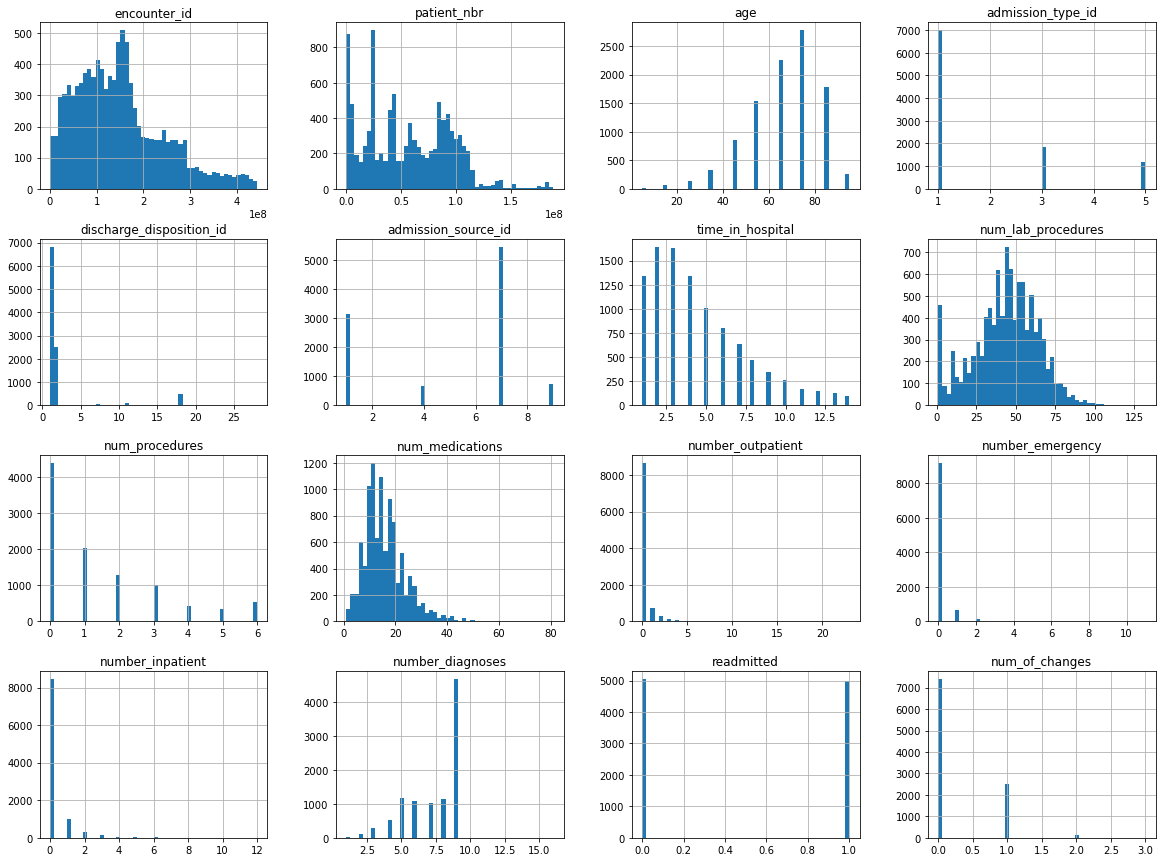

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
train1.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:xlabel='age', ylabel='count'>

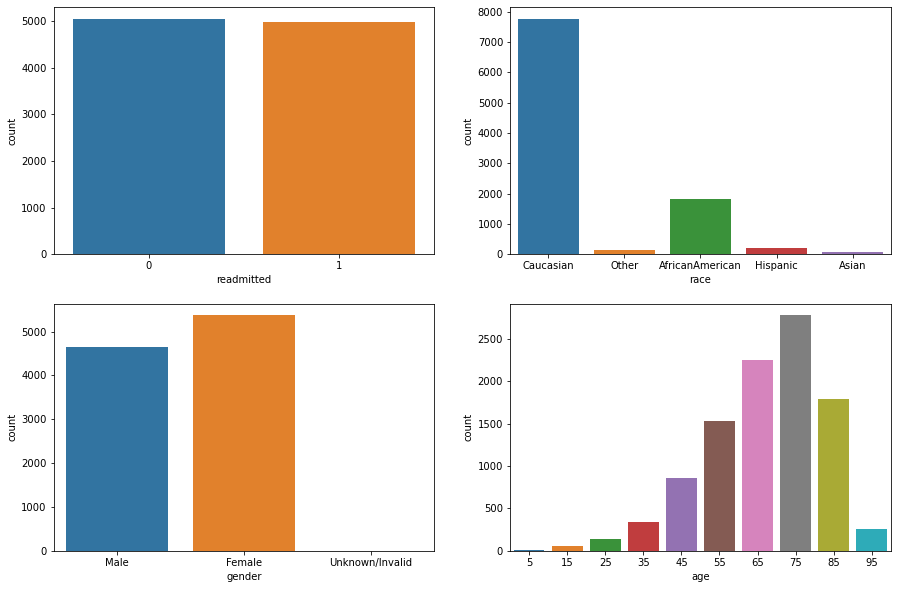

In [35]:
fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=2)

sns.countplot(x="readmitted", data=train1, ax=ax[0][0])
sns.countplot(x="race", data=train1, ax=ax[0][1])
sns.countplot(x="gender", data=train1, ax=ax[1][0])
sns.countplot(x="age", data=train1, ax=ax[1][1])

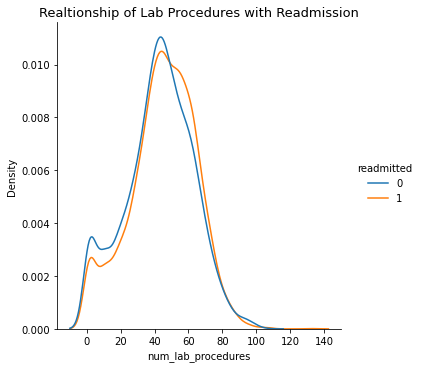

In [62]:
sns.displot(train1, x="num_lab_procedures", hue= 'readmitted', kind="kde")
plt.title('Realtionship of Lab Procedures with Readmission', size = 13)
plt.show()

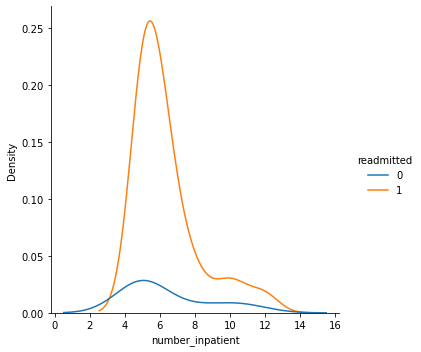

In [65]:
sns.displot(train1.loc[train1['number_inpatient']>=5], x="number_inpatient", hue= 'readmitted', kind='kde')
plt.show()



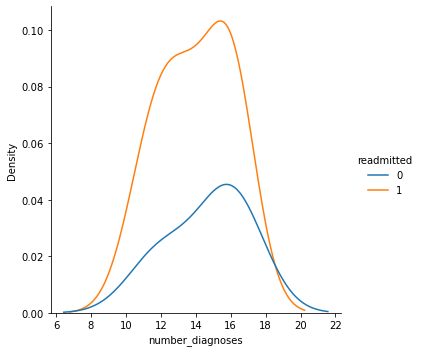

In [67]:
sns.displot(train1[train1['number_diagnoses'] > 10], x="number_diagnoses", hue= 'readmitted', kind='kde')



Text(0.5, 1.0, 'Max Glu Serum vs Readmission')

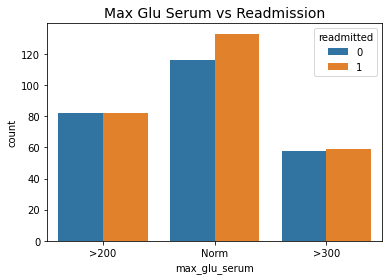

In [75]:
sns.countplot(x='max_glu_serum',  hue= 'readmitted', data= train1[train1['max_glu_serum']!='None'])
plt.title('Max Glu Serum vs Readmission', size = 14)

Text(0.5, 1.0, 'A1Cresult vs Readmission')

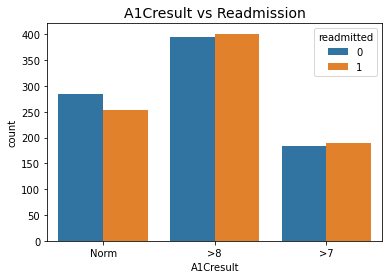

In [76]:
sns.countplot(x='A1Cresult', hue = 'readmitted', data=train1[train1['A1Cresult']!='None'])
plt.title('A1Cresult vs Readmission', size = 14)


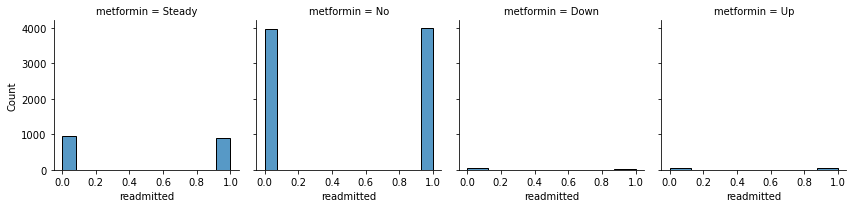

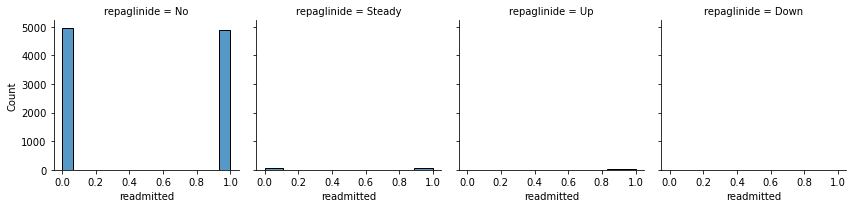

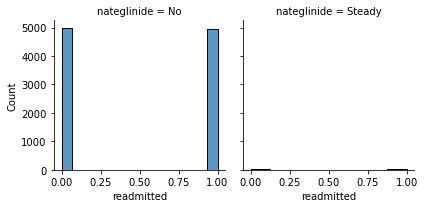

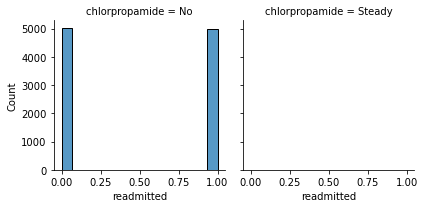

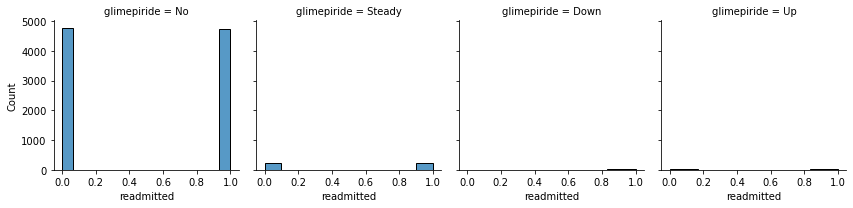

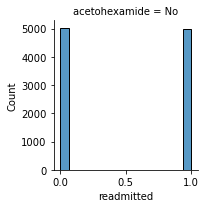

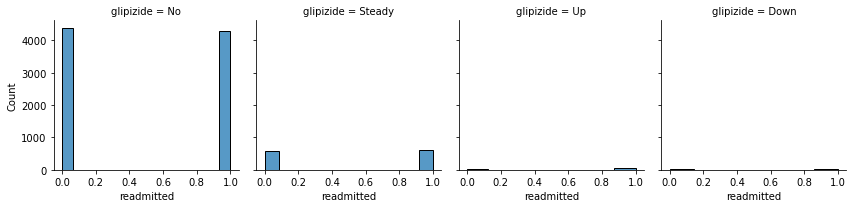

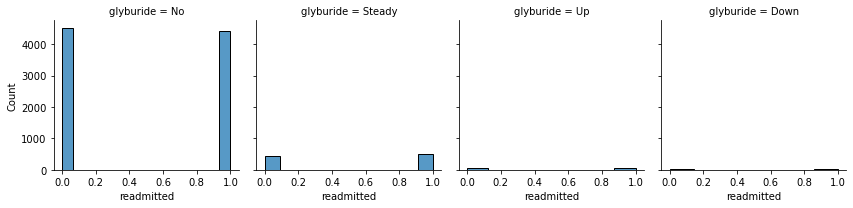

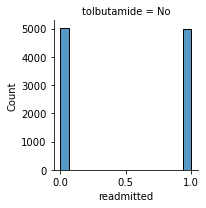

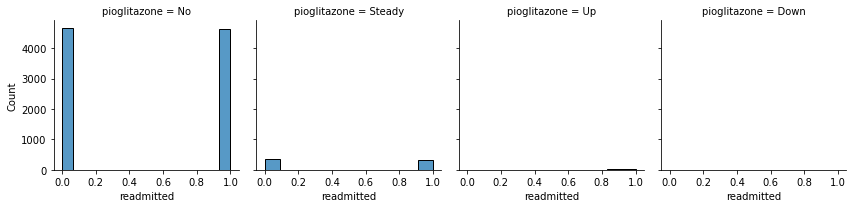

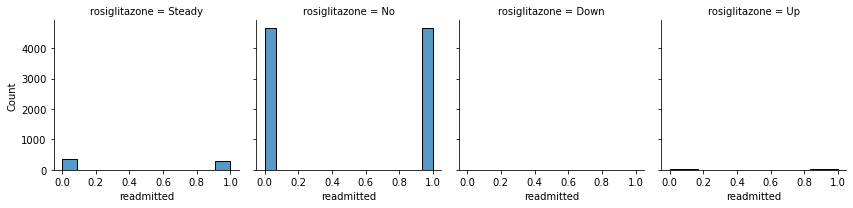

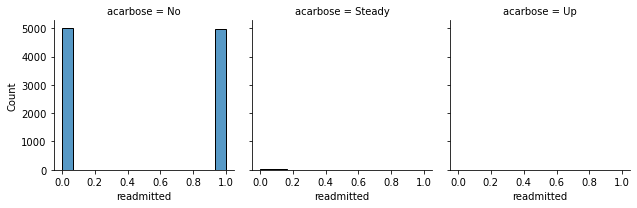

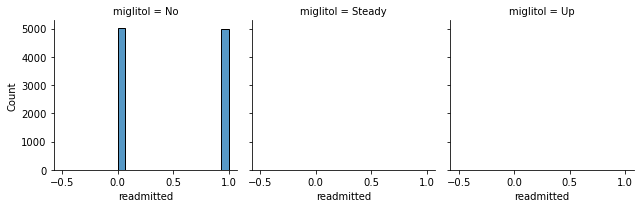

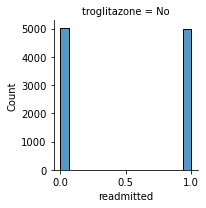

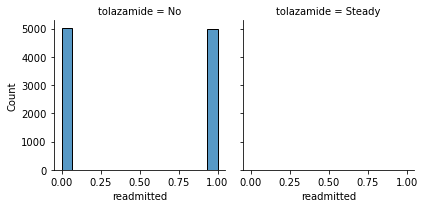

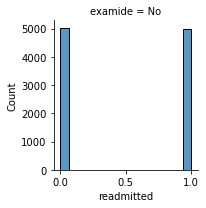

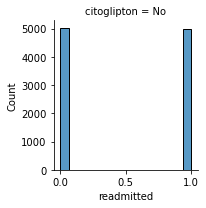

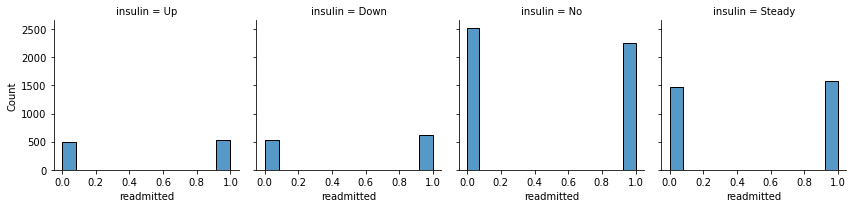

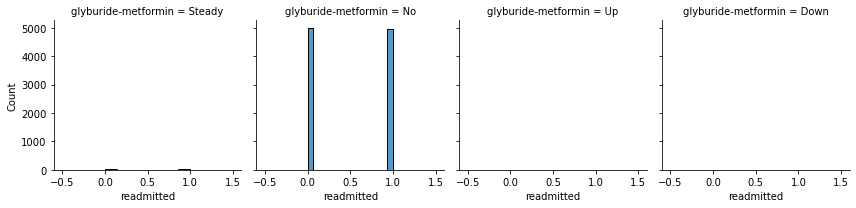

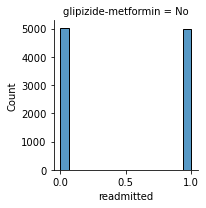

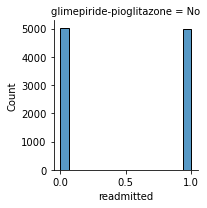

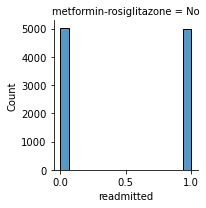

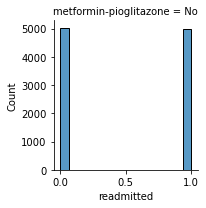

In [83]:
for columnName in train1.iloc[:, 22:45].columns:
    g = sns.FacetGrid(train1, col=columnName)
    g.map(sns.histplot, "readmitted")
    plt.show()

In [101]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [93]:
# Fitting a prelim model
logit_model = sm.logit(formula = 'readmitted~time_in_hospital+num_medications+time_in_hospital+number_inpatient+number_diagnoses:num_procedures+discharge_disposition_id+number_diagnoses+number_inpatient+acarbose+metformin', data = train1).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.679140
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10011
Method:                           MLE   Df Model:                           11
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                 0.02018
Time:                        21:42:20   Log-Likelihood:                -6807.0
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 1.146e-53
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.0761      0.253     -4.251      0.000      -1.572      -0.580
acarbose[T.Steady]                 -0.2816      0.438     -0.643      0.520      -1.140       0.577
acarbose[T.Up]                      0.7238      1.233      0.587      0.557      -1.692       3.140
metformin[T.No]                     0.2827      0.239      1.181      0.238      -0.187       0.752
metformin[T.Steady]                 0.2371      0.243      0.977      0.329      -0.239       0.713
metformin[T.Up]                    -0.1132      0.312     -0.363      0.717      -0.725       0.498
time_in_hospital                    0.0370      0.008      4.761      0.000       0.022       0.052
num_medications                     0.0091      0.003      2.979      0.003       0.003       0.015
number_inpatient                    0.3508      0.032     10.990      0.000       0.288       0.413
number_diagnoses:num_procedures    -0.0050      0.002     -3.070      0.002      -0.008      -0.002
discharge_disposition_id            0.0098      0.005      1.921      0.055      -0.000       0.020
number_diagnoses                    0.0580      0.011      5.186      0.000       0.036       0.080
===================================================================================================
"""

Classification accuracy = 65.0%
Precision = 11.5%
TPR or Recall = 42.0%
FNR = 58.0%
FPR = 32.7%
ROC-AUC = 55.8%


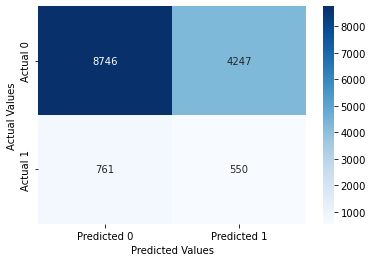

In [102]:
confusion_matrix_data(test,test.readmitted,logit_model)

In [113]:
# Fitting a prelim model
logit_model2 = sm.logit(formula = 'readmitted~time_in_hospital+gender+acarbose+age+number_inpatient', data = train1).fit() #Developing logistic regression model
logit_model2.summary()

         Current function value: 0.679908
         Iterations: 35


/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10015
Method:                           MLE   Df Model:                            7
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                 0.01908
Time:                        21:48:14   Log-Likelihood:                -6814.7
converged:                      False   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 1.737e-53
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.8178      0.096     -8.477      0.000      -1.007      -0.629
gender[T.Male]                0.0026      0.041      0.064      0.949      -0.077       0.082
gender[T.Unknown/Invalid]   -19.0550   1.58e+04     -0.001      0.999    -3.1e+04     3.1e+04
acarbose[T.Steady]           -0.3201      0.439     -0.729      0.466      -1.181       0.540
acarbose[T.Up]                0.7160      1.225      0.584      0.559      -1.685       3.117
time_in_hospital              0.0472      0.007      6.922      0.000       0.034       0.061
age                           0.0075      0.001      5.652      0.000       0.005       0.010
number_inpatient              0.3659      0.032     11.520      0.000       0.304       0.428
=============================================================================================
"""

Classification accuracy = 66.7%
Precision = 12.7%
TPR or Recall = 45.0%
FNR = 55.0%
FPR = 31.1%
ROC-AUC = 60.1%


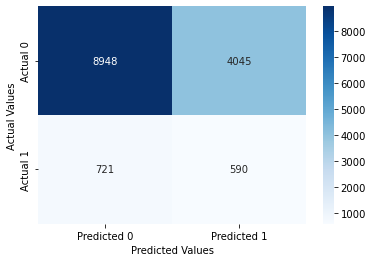

In [114]:
confusion_matrix_data(test,test.readmitted,logit_model2)